<a href="https://colab.research.google.com/github/antoninodimaggio/PyTorch-Adversarial-Examples/blob/master/FGSM_Attack_On_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Gradient Sign Method (FGSM) Attack On MNIST
## Non-Technical Overview
* An adversarial example is when you mess up an image in order to fool a Convolutional Neural Network (CNN) into classifying an image into a different class.
* This notebook focuses on an attack method known as FGSM, a white-box attack  that requires knowledge of the gradients used to train the model.
* First we have to train a MNIST classifier using PyTorch.

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
device = torch.device('cuda')
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), 1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

num_epochs = 14
print('Start training ...')
for epoch in range(num_epochs):
  training_loss = 0.0
  model.train()
  for batch, (inputs, labels) in enumerate(train_loader, 0):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
  print('Training --> Epoch: %d, Epoch Loss: %1.8f LR: %1.8f' % (epoch+1, training_loss/len(train_loader), optimizer.param_groups[0]['lr']))
  scheduler.step()
print('Done training!')

Start training ...
Training --> Epoch: 1, Epoch Loss: 0.40580175 LR: 1.00000000
Training --> Epoch: 2, Epoch Loss: 0.21604351 LR: 0.70000000
Training --> Epoch: 3, Epoch Loss: 0.18363507 LR: 0.49000000
Training --> Epoch: 4, Epoch Loss: 0.16385339 LR: 0.34300000
Training --> Epoch: 5, Epoch Loss: 0.15550355 LR: 0.24010000
Training --> Epoch: 6, Epoch Loss: 0.14508551 LR: 0.16807000
Training --> Epoch: 7, Epoch Loss: 0.14054043 LR: 0.11764900
Training --> Epoch: 8, Epoch Loss: 0.13119109 LR: 0.08235430
Training --> Epoch: 9, Epoch Loss: 0.13560269 LR: 0.05764801
Training --> Epoch: 10, Epoch Loss: 0.13247509 LR: 0.04035361
Training --> Epoch: 11, Epoch Loss: 0.13092068 LR: 0.02824752
Training --> Epoch: 12, Epoch Loss: 0.12670590 LR: 0.01977327
Training --> Epoch: 13, Epoch Loss: 0.13069979 LR: 0.01384129
Training --> Epoch: 14, Epoch Loss: 0.13026178 LR: 0.00968890
Done training!


Evaluating the accuracy of the model on the test data set.

In [6]:
correct = 0
total = 0
model.eval() # make sure we are in eval mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10,000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10,000 test images: 98 %


## Example MNIST Images
* MNIST is a collection of 60,000 handwritten digits, we trained the model using 50,00 of these images
* Here I am just showing an example of what the images look like so they can be compared to to the adversarial examples later on

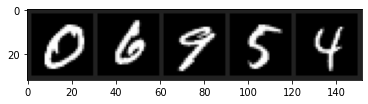

In [7]:
import matplotlib.pyplot as plt

mean = torch.tensor([0.1307], dtype=torch.float32)
std = torch.tensor([0.3081], dtype=torch.float32)
inverse_transform = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
images, _ = next(iter(train_loader))
grid = inverse_transform(torchvision.utils.make_grid(images[0:5], nrow=5).permute(1, 2, 0))
plt.imshow(grid)
plt.show()

## Some Extremley Helpful Tools
* I am going to be using IBM's [Adversarial Robustness Toolbox (ART)](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/guide/setup.html) to help me out
* The [FGSM](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm) documentation for ART 

In [8]:
!pip install adversarial-robustness-toolbox
import numpy as np
from art.attacks import FastGradientMethod
from art.classifiers import PyTorchClassifier

     |████████████████████████████████| 491kB 8.7MB/s 
     |████████████████████████████████| 7.1MB 22.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## FGSM Method Explained
* Majority of this is taken from this [PyTorch tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) 
* Essentially FGSM is a function that perturbs the original input image. The FGSM attack function takes three inputs, the original clean image which is $(x)$, epsilon which is the pixel-wise perturbation amount $(\epsilon)$, and the gradient of the loss w.r.t the input image $\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$. The sign function (signum function) simply extracts the sign of a real number. <br> <br>
<center>$x\_adv = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$</center> <br>
* On a side note, something interesting about generating adversarial examples using one-step methods such as FGSM. If y != None (y=None by default) when generating x_adv, then we would instead use the true label to generate adversarial examples. If I were to train a CNN using these adversarial examples to increase robustness I would leak information about the label, since x_adv would contain extra information about the gradient ([math behind this](http://jackhaha363.github.io/post/label_leak/)). This would make classifying x_adv an easier problem than classifying x! This is not a huge problem with MNIST since the difficulty gap between x and x_adv is not too bad, but this can become an issue with a data set such as CIFAR-10 or ImageNet.
  * https://arxiv.org/pdf/1611.01236.pdf


Accuracy of the network against 10,000 adversarial attack images with an eps of 0.10 : 93 %


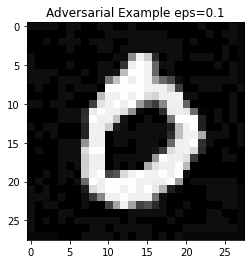

Accuracy of the network against 10,000 adversarial attack images with an eps of 0.20 : 80 %


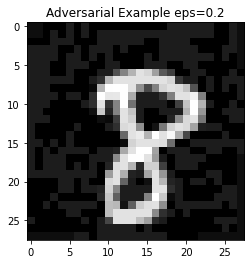

Accuracy of the network against 10,000 adversarial attack images with an eps of 0.30 : 61 %


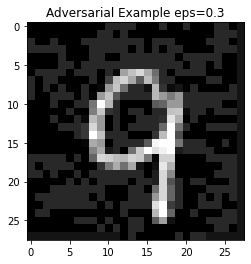

Accuracy of the network against 10,000 adversarial attack images with an eps of 0.40 : 42 %


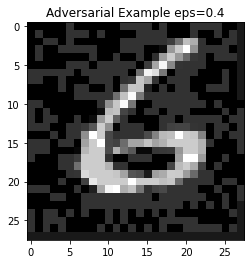

Accuracy of the network against 10,000 adversarial attack images with an eps of 0.50 : 27 %


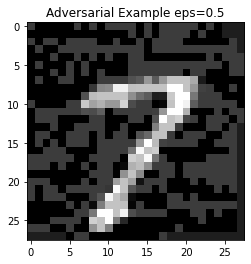

In [11]:
classifier = PyTorchClassifier(model, criterion, optimizer, (1, 28, 28), 10, device_type='gpu')
attack = FastGradientMethod(classifier=classifier, eps=0.1, batch_size=1)
eps = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracy = []
for i in eps:
  correct = 0
  total = 0
  for images, labels in test_loader:
    target_image = images.numpy()
    attack.set_params(eps=i)
    x_adv = attack.generate(x=target_image, y=None)
    predicted = torch.tensor([np.argmax(classifier.predict(x_adv))])
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  
  acc = (100 * correct / total)
  accuracy.append(acc)
  print('Accuracy of the network against 10,000 adversarial attack images with an eps of %1.2f : %d %%' % (
        i , acc))

  # examples of perturbed images
  adv_image_tensor = torch.from_numpy(x_adv)
  img = inverse_transform(torch.squeeze(adv_image_tensor, dim=0))
  plt.imshow(torch.squeeze(img, dim=0).numpy(), cmap="gray")
  plt.title('Adversarial Example eps=' + str(i))
  plt.show(block=False)

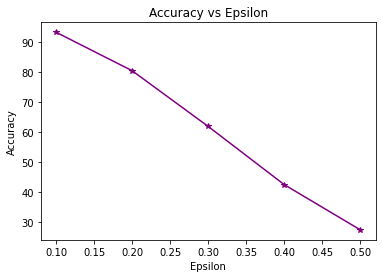

In [13]:
# demonstrate how accuracy decreases as eps increases
plt.plot(eps, accuracy, "*-", color='purple')
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()